In [1]:
!git clone https://github.com/DhruvJawalkar/Depth-Map-Prediction-from-a-Single-Image-using-a-Multi-Scale-Deep-Network.git

import os
os.chdir('Depth-Map-Prediction-from-a-Single-Image-using-a-Multi-Scale-Deep-Network')

  
import torch

from urllib.request import urlretrieve
from torchvision import transforms
from dataset import NYUDataset
from custom_transforms import *
import plot_utils
import model_utils
from nn_model import Net
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%matplotlib inline
import torch.nn.functional as F

Cloning into 'Depth-Map-Prediction-from-a-Single-Image-using-a-Multi-Scale-Deep-Network'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 60 (delta 17), reused 29 (delta 4), pack-reused 0
Unpacking objects: 100% (60/60), done.


In [ ]:
bs = 8
sz = (320,240)
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
mean, std = torch.tensor(mean), torch.tensor(std)
unnormalize = UnNormalizeImgBatch(mean, std)

tfms = transforms.Compose([
    ResizeImgAndDepth(sz),
    RandomHorizontalFlip(),
    ImgAndDepthToTensor(),
    NormalizeImg(mean, std)
])

In [3]:
print(os.getcwd())

/content/Depth-Map-Prediction-from-a-Single-Image-using-a-Multi-Scale-Deep-Network


In [4]:
nyu_depth_data_labeled = 'http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_data_labeled.mat'

download_path = os.path.join(os.getcwd(), 'data/nyu_depth_data_labeled.mat')
urlretrieve(nyu_depth_data_labeled,download_path)

nyu_depth_v2_labeled = 'http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat'
download_path = os.path.join(os.getcwd(), 'data/nyu_depth_v2_labeled.mat')
urlretrieve(nyu_depth_data_labeled,download_path)


('/content/Depth-Map-Prediction-from-a-Single-Image-using-a-Multi-Scale-Deep-Network/data/nyu_depth_v2_labeled.mat',
 <http.client.HTTPMessage at 0x7f4adff23da0>)

In [ ]:
ds = NYUDataset('data/', tfms)
dl = torch.utils.data.DataLoader(ds, bs, shuffle=True)

In [6]:
ds[0][0].shape

torch.Size([3, 240, 320])

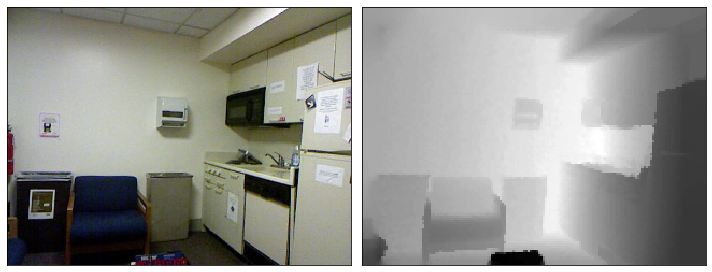

In [7]:
i = 1
plot_utils.plot_image(model_utils.get_unnormalized_ds_item(unnormalize, ds[i]))


In [8]:
model = Net()
model.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:08<00:00, 67106096.62it/s]


Net(
  (VGG): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256,

In [10]:
model_ckpt_url = 'https://storage.googleapis.com/ucl-interior-desing/nyu_dnl_pretrained.ckpt'
download_path = os.path.join(os.getcwd(), 'data/all-scales-trained.ckpt')
urlretrieve(model_ckpt_url,download_path)


('/content/Depth-Map-Prediction-from-a-Single-Image-using-a-Multi-Scale-Deep-Network/data/all-scales-trained.ckpt',
 <http.client.HTTPMessage at 0x7f4adb1a4710>)

In [11]:
model.load_state_dict(torch.load('data/nyu_dnl_pretrained.ckpt', map_location="cpu"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [ ]:
model.train()
n_epochs = 0
lr = 0.0000005
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = lr)

total_steps = 0
for e in range(n_epochs):
    for batch, labels in dl:
        optimizer.zero_grad()
        
        batch = batch.to(device)
        labels = labels.to(device)
        
        preds = model(batch)
        loss = model_utils.depth_loss(preds, labels) 
        
        loss.backward()
        optimizer.step()
        
        total_steps +=1
                                                       
        model_utils.print_training_loss_summary(loss.item(), total_steps, e+1, n_epochs, len(dl))

In [13]:
%%time
with torch.no_grad():
    model.eval()
    img, depth = iter(dl).next()
    preds = model(img.to(device))

CPU times: user 9.94 s, sys: 0 ns, total: 9.94 s
Wall time: 10.4 s


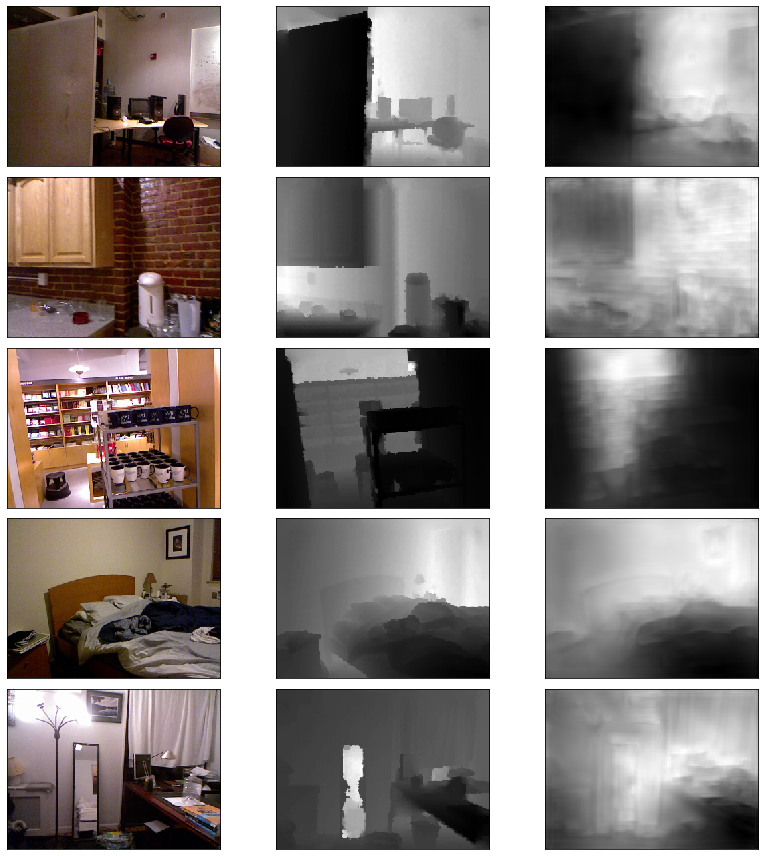

In [14]:
plot_utils.plot_model_predictions_on_sample_batch(images=unnormalize(img), depths=depth, preds=preds.squeeze(dim=1), plot_from=0)